<a href="https://colab.research.google.com/github/josephmcg16/nel/blob/main/Fluid_Properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import Code Libraries
import pandas as pd
import numpy as np

from scipy import optimize
from sklearn.metrics import mean_squared_error  # cost function

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
#@title # Scrape NIST Data
#@markdown Data from [NIST Chemistry WebBook, SRD 69 - Thermophysical Properties of Fluid Systems](https://webbook.nist.gov/chemistry/fluid/)
TEMP_MIN = 5 #@param {type:"number"}
TEMP_MAX = 50 #@param {type:"number"}
TEMP_INCREMENT = 5 #@param {type:"number"}
PRESS_MIN = 3 # @param {type:"number"}
PRESS_MAX = 46 #@param {type:"number"}
PRESS_INCREMENT = 1 #@param {type:"number"}
FLUID = "CO2" #@param ["CO2", "N2", "CH4"]

GAS_CONSTANT_DICT = {
    "CO2": 188.9,
    "N2" : 296.8,
    "CH4" : 518.2
}  # J/kg.K
FLUIDS_DICT = {
  "CO2": "C124389",
  "N2": "C7727379",
  "CH4": "C74828"
  }  # NIST webhook IDs


def scrape_nist_data(fluid, isotherm, pressure_range):
    pressure_inc = (pressure_range[-1] - pressure_range[0]) / (len(pressure_range) - 1)
    path = f"https://webbook.nist.gov/cgi/fluid.cgi?Action=Load&ID={FLUIDS_DICT[FLUID]}&Type=IsoTherm&Digits=5&PLow={pressure_range[0]}&PHigh={pressure_range[-1]}&PInc={pressure_inc}&T={isotherm}&RefState=DEF&TUnit=C&PUnit=bar&DUnit=kg%2Fm3&HUnit=kJ%2Fkg&WUnit=m%2Fs&VisUnit=cP&STUnit=N%2Fm"
    nist_site_data = pd.read_html(path)[0]
    return nist_site_data

temperature_range = np.arange(
    TEMP_MIN, TEMP_MAX + TEMP_INCREMENT, TEMP_INCREMENT)  # degC
pressure_range = np.arange(
    PRESS_MIN, PRESS_MAX + PRESS_INCREMENT, PRESS_INCREMENT)  # bar


# loop over each isotherm and append to pandas dataframe
df = pd.DataFrame()
for isotherm in temperature_range:
    df = df.append(scrape_nist_data(FLUID, isotherm, pressure_range))

df['Compressibility Factor'] =  10 ** 5 * df['Pressure (bar)'] / (df['Density (kg/m3)'] * (df['Temperature (C)'] + 273.15) * GAS_CONSTANT_DICT[FLUID])
df = df[df['Phase'] == 'vapor']
df.to_excel(f"{FLUID} NIST DATA.xlsx")

Z_true = df['Compressibility Factor'].to_numpy()
pressure = df['Pressure (bar)'].to_numpy()  # bar
temperature = df['Temperature (C)'].to_numpy() + 273.15  # K

pi = pressure / 50
tau = 300 / temperature

df

,Temperature (C),Pressure (bar),Density (kg/m3),Volume (m3/kg),Internal Energy (kJ/kg),Enthalpy (kJ/kg),Entropy (J/g*K),Cv (J/g*K),Cp (J/g*K),Sound Spd. (m/s),Joule-Thomson (K/bar),Viscosity (cP),Therm. Cond. (W/m*K),Phase,Compressibility Factor
0,5.0,3.0,5.8194,0.171840,435.28,486.83,2.4678,0.64398,0.85006,258.34,1.30980,0.013966,0.015238,vapor,0.981142
1,5.0,4.0,7.8105,0.128030,434.50,485.71,2.4107,0.64750,0.85980,257.37,1.31060,0.013974,0.015302,vapor,0.974698
2,5.0,5.0,9.8289,0.101740,433.71,484.58,2.3656,0.65108,0.86987,256.40,1.31150,0.013982,0.015368,vapor,0.968175
3,5.0,6.0,11.8760,0.084207,432.90,483.43,2.3283,0.65473,0.88031,255.41,1.31240,0.013992,0.015437,vapor,0.961546
4,5.0,7.0,13.9510,0.071677,432.09,482.27,2.2962,0.65845,0.89113,254.41,1.31340,0.014001,0.015508,vapor,0.954952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,50.0,42.0,83.7720,0.011937,440.03,490.17,2.0184,0.76909,1.21960,252.39,0.88461,0.017027,0.022047,vapor,0.821324
40,50.0,43.0,86.2780,0.011590,439.25,489.09,2.0115,0.77176,1.23360,251.70,0.88377,0.017066,0.022185,vapor,0.816455
41,50.0,44.0,88.8190,0.011259,438.45,487.99,2.0045,0.77447,1.24810,251.00,0.88287,0.017108,0.022328,vapor,0.811541
42,50.0,45.0,91.3940,0.010942,437.64,486.88,1.9977,0.77721,1.26310,250.30,0.88192,0.017150,0.022476,vapor,0.806601


In [ ]:
#@title # Equation of State Functional Form
#@markdown Functional form for the fit:
#@markdown $Z = 1 + \pi(a_1.\tau^{0.75}+a_2.\tau^{1.25}+a_3.\tau^3) + \pi^2.a_4.\tau^2+\pi^3\tau^{1.5}.(a_5+a_6.\tau^{0.25})$
#@markdown - $Z$ is the compressibility factor
#@markdown - $\pi=p/(50\times 10^5)$ is the normalized pressure.
#@markdown - $\tau=300/T$ is the normalized temperature.

def model(a_vec, pi, tau):
    Z = 1 + pi * (a_vec[0] * tau ** 0.75 + a_vec[1] * tau ** 1.25 + a_vec[2] * tau ** 3) \
        + pi ** 2 * a_vec[3] * tau ** 2 \
        + pi ** 3 * tau ** 1.5 * (a_vec[4] + a_vec[5] * tau ** 0.25)
    return Z

In [ ]:
#@title # Density Fit (Linear Regression)
#@markdown Linear model: $Z=\vec{a}^\top X\ ,\ \vec{a}\in\mathbb{R}^6 $ 
#@markdown
#@markdown Where $x_i=\phi(\pi, \tau)\ ,\ x_i\in X\subseteq\mathbb{R}^{n\times 6}$
#@markdown
#@markdown $n$ is the number of reference samples in the operating range.
#@markdown
#@markdown The objective is to minimize the square error, $\ J=|Z-\vec{a}^T X|^2$
#@markdown
#@markdown Setting $\partial J/\partial \vec{a} = 0$ leads to:
#@markdown
#@markdown $\vec{a}=(X^\top X)^{-1}X^\top Z$

def linear_least_squares(Z_true, pi, tau):
    X = np.asarray([
        pi * tau ** 0.75,
        pi * tau ** 1.25, 
        pi * tau ** 3,
        pi ** 2 * tau ** 2,
        pi ** 3 * tau ** 1.5,
        pi ** 3 * tau ** 1.75
    ]).T
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Z_true-1)

def console_output(a_lsq, df):
    for i, a in enumerate(a_lsq):
        print(f"a{i+1} = {a:.3e}")
    print(f"\nMeanRelErr = {df['Relative Error (%)'].abs().mean():.3e} %")
    print(f"MaxRelErr = {df['Relative Error (%)'].abs().max():.3e} %")
    print(f"MinRelErr = {df['Relative Error (%)'].abs().min():.3e} %\n")
    return

a_lsq = linear_least_squares(Z_true, pi, tau)
df['Predicted Compressbility Factor'] = model(a_lsq, pi, tau)
df['Relative Error (%)'] = 100 * (df['Predicted Compressbility Factor'] - Z_true) / Z_true
console_output(a_lsq, df)

a1 = -3.627e+00
a2 = 4.706e+00
a3 = -1.323e+00
a4 = -1.169e-02
a5 = 3.066e+00
a6 = -3.128e+00

MeanRelErr = 1.222e-01 %
MaxRelErr = 1.477e+00 %
MinRelErr = 4.344e-04 %



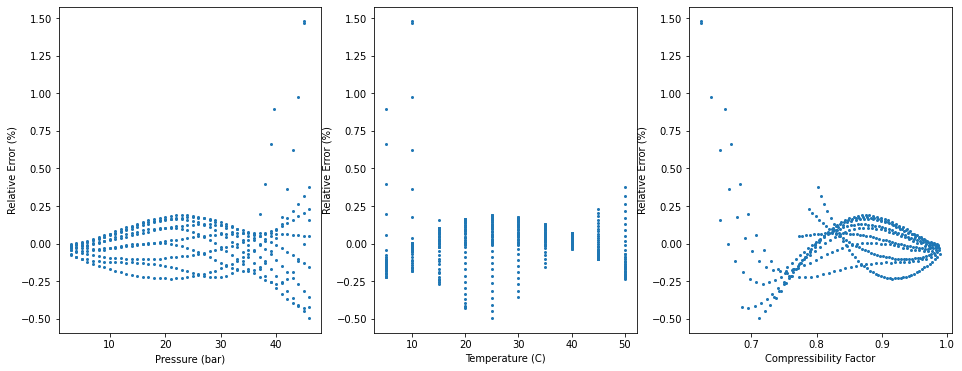

In [ ]:
#@title Error Plots (Linear Regression)
# scrape saturation line data from NIST webhook
df_sat = pd.read_html(f"https://webbook.nist.gov/cgi/fluid.cgi?PLow={PRESS_MIN}&PHigh={PRESS_MAX}&PInc={PRESS_INCREMENT}&Digits=5&ID={FLUIDS_DICT[FLUID]}&Action=Load&Type=SatT&TUnit=C&PUnit=bar&DUnit=kg%2Fm3&HUnit=kJ%2Fkg&WUnit=m%2Fs&VisUnit=cP&STUnit=N%2Fm&RefState=DEF#Vapor")[0]

# 2d plots of data vs error
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.plot(df['Pressure (bar)'], df['Relative Error (%)'], '.', markersize=4)
plt.xlabel('Pressure (bar)')
plt.ylabel('Relative Error (%)')
plt.subplot(132)
plt.xlabel('Temperature (C)')
plt.ylabel('Relative Error (%)')
plt.plot(df['Temperature (C)'], df['Relative Error (%)'], '.', markersize=4)
plt.subplot(133)
plt.xlabel('Compressibility Factor')
plt.ylabel('Relative Error (%)')
plt.plot(df['Compressibility Factor'], df['Relative Error (%)'], '.', markersize=4)
plt.show()

# 3d scatter plot of the data vs error and saturation line
fig = px.scatter_3d(
    df, 
    x='Temperature (C)', 
    y='Pressure (bar)', 
    z='Relative Error (%)', 
    width=1000, height=400)
fig.add_trace(go.Scatter3d(
    x=df_sat['Temperature (C)'], 
    y=df_sat['Pressure (bar)'], 
    z=[0]*len(df_sat), 
    name='Sat Line'))
fig.update_traces(marker_size=1)
fig.update_layout(
    margin=dict(l=5, r=250, t=20, b=5)
)
fig.write_html("error_plot.html")
fig.show()

a1 = -3.675
a2 = 4.771
a3 = -1.338
a4 = -0.014
a5 = 3.036
a6 = -3.096

Optimal Cost = 9.580e-07
Std Dev of Local Minima = 1.803e-06

MeanRelErr = -1.189e-03 %
MaxRelErr = 1.510e+00 %
MinRelErr = 4.968e-05 %



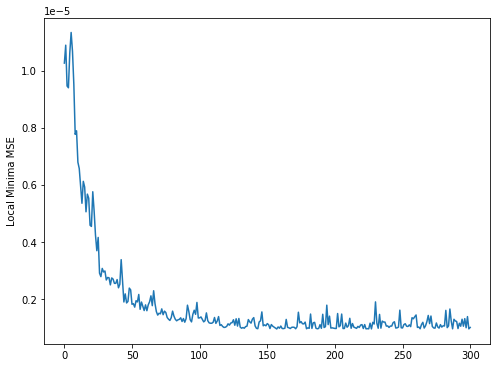

In [ ]:
#@title # Density Fit (Nonlinear Regression)

# init
np.random.seed(1)
x0 = np.random.uniform(low=-1, high=1, size=(6,))
f_list = []

def callback(x, f, accept):
    # print(f"Local Minima Found {f:.3e}")
    f_list.append(f)


def console_output(result, df):
    for i, a in enumerate(result. x):
        print(f"a{i+1} = {a:.3f}")
    print(f"\nOptimal Cost = {result.fun:.3e}")
    print(f"Std Dev of Local Minima = {np.std(f_list):.3e}")
    print(f"\nMeanRelErr = {df['Relative Error (%)'].mean():.3e} %")
    print(f"MaxRelErr = {df['Relative Error (%)'].abs().max():.3e} %")
    print(f"MinRelErr = {df['Relative Error (%)'].abs().min():.3e} %\n")
    return


def objective(a_vec, Z_true, pi, tau):
    """Cost function for the nonlinear regression."""
    return 0.5 * mean_squared_error(Z_true, model(a_vec, pi, tau))


# GO hyper-parameter search?
result = optimize.basinhopping(
    objective,
    x0,
    niter=300,
    T=1e-7,
    callback=callback,
    minimizer_kwargs={'args':(Z_true, pi, tau)}
    )

df['Predicted Compressbility Factor'] = model(result.x, pi, tau)
df['Relative Error (%)'] = 100 * (df['Predicted Compressbility Factor'] - Z_true) / Z_true
console_output(result, df)

plt.figure(figsize=(8, 6))
plt.plot(f_list)
plt.ylabel('Local Minima MSE')
plt.show()

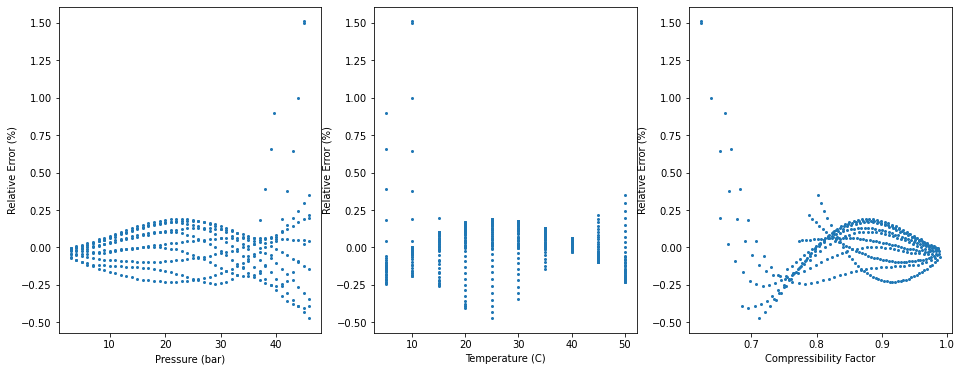

In [ ]:
#@title Error Plots (Nonlinear Regression)
# scrape saturation line data from NIST webhook
df_sat = pd.read_html(f"https://webbook.nist.gov/cgi/fluid.cgi?PLow={PRESS_MIN}&PHigh={PRESS_MAX}&PInc={PRESS_INCREMENT}&Digits=5&ID={FLUIDS_DICT[FLUID]}&Action=Load&Type=SatT&TUnit=C&PUnit=bar&DUnit=kg%2Fm3&HUnit=kJ%2Fkg&WUnit=m%2Fs&VisUnit=cP&STUnit=N%2Fm&RefState=DEF#Vapor")[0]

# 2d plots of data vs error
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.plot(df['Pressure (bar)'], df['Relative Error (%)'], '.', markersize=4)
plt.xlabel('Pressure (bar)')
plt.ylabel('Relative Error (%)')
plt.subplot(132)
plt.xlabel('Temperature (C)')
plt.ylabel('Relative Error (%)')
plt.plot(df['Temperature (C)'], df['Relative Error (%)'], '.', markersize=4)
plt.subplot(133)
plt.xlabel('Compressibility Factor')
plt.ylabel('Relative Error (%)')
plt.plot(df['Compressibility Factor'], df['Relative Error (%)'], '.', markersize=4)
plt.show()

# 3d scatter plot of the data vs error and saturation line
fig = px.scatter_3d(
    df, 
    x='Temperature (C)', 
    y='Pressure (bar)', 
    z='Relative Error (%)', 
    width=1000, height=400)
fig.add_trace(go.Scatter3d(
    x=df_sat['Temperature (C)'], 
    y=df_sat['Pressure (bar)'], 
    z=[0]*len(df_sat), 
    name='Sat Line'))
fig.update_traces(marker_size=1)
fig.update_layout(
    margin=dict(l=5, r=250, t=5, b=5)
)
fig.write_html("error_plot.html")
fig.show()